# Line plot animation

In [1]:
# Import modules
import datacube 
import sys
import xarray as xr
import numpy as np
import calendar
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patheffects as PathEffects
import matplotlib.patches as patches
import matplotlib.dates as mdates
import matplotlib.lines as mlines
from skimage import exposure
from datacube.utils import geometry
from datacube.utils.geometry import CRS
from datetime import datetime, timedelta

# Import external dea-notebooks functions using relative link to Scripts directory
sys.path.append('../Scripts')
import DEADataHandling
import DEAPlotting

# Compute index
def tss(ds):
    rrs = (ds.nir / 10000.0) / 3.14
    tss_da = 5.184 + 1349.63 * rrs + 614561.673 * rrs**2
    return(tss_da)

# Set up datacube instance
dc = datacube.Datacube(app='Time series animation')

# Study area name used for output file
study_area = 'line-test'
masked_prop = 0.96

# Set up analysis data query using a buffer around a lat-long point
lat, lon, buffer = -19.6535147591, 147.566809667, 10000
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer, x + buffer),
         'y': (y - buffer, y + buffer),    
         'time': ('2014-06-01', '2018-12-30'),
         'resolution': (-40, 40),
         'resampling': 'bilinear',
         'crs': 'EPSG:3577'}


## Extract cloud-free clear Landsat observations from all sensors
Use the `load_clearlandsat` function to load Landsat observations and PQ data for multiple sensors (i.e. ls5, ls7, ls8), and return a single xarray dataset containing only observations that contain greater than a specified proportion of clear pixels. This uses `dask` to only load in the filtered observations, and results in a visually appealing time series of observations that are not affected by cloud.

In [2]:
# Custom mask that includes only cloudy or cloud shadowed pixels with data for all bands
custom_mask = {'cloud_acca': 'no_cloud', 
               'cloud_fmask': 'no_cloud', 
               'contiguous': True}

# Load in data
ds1 = DEADataHandling.load_clearlandsat(dc=dc, query=query, product='nbart', 
                                        bands_of_interest=['red', 'green', 'blue', 'nir'], 
                                        masked_prop=masked_prop, mask_dict=custom_mask, apply_mask=False)  


Loading ls5 PQ
    Skipping ls5
Loading ls7 PQ
    Loading 7 filtered ls7 timesteps
Loading ls8 PQ
    Loading 16 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data


##  Extract polygon drill data
This is used to plot a line on the right panel of the animation

<bound method NDFrame.head of                                 nir
time                               
2014-06-21 00:10:20.000   15.136350
2014-07-07 00:10:27.000   10.735953
2014-07-23 00:10:30.000    9.212924
2014-08-08 00:10:39.000   28.750844
2014-08-24 00:10:42.000    7.717374
2014-09-01 00:08:15.500   18.370227
2014-09-17 00:08:18.500   24.971502
2015-05-23 00:09:41.000   13.340893
2015-06-24 00:09:56.500   34.332037
2015-07-02 00:10:16.500   20.295996
2015-09-04 00:10:28.500   18.000032
2015-09-12 00:10:31.500   44.176369
2016-02-27 00:12:32.000   27.535517
2016-04-23 00:10:08.500   11.643310
2016-06-10 00:10:19.000    9.104494
2016-06-26 00:10:25.000   26.351356
2016-07-28 00:10:38.000  162.447034
2016-08-05 00:13:14.500   18.370227
2016-08-13 00:10:40.000   13.415678
2016-12-03 00:10:57.000   54.886523
2017-04-10 00:10:07.500   14.414051
2017-05-28 00:10:11.000   27.296192
2018-04-05 00:11:31.500  321.741517>


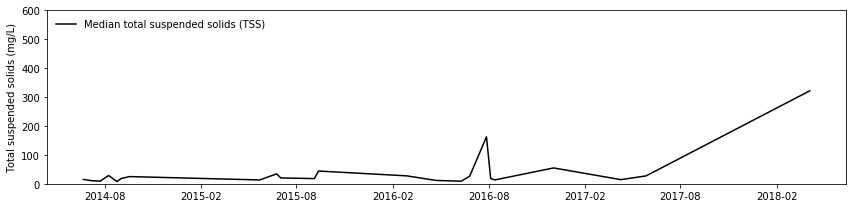

In [3]:
# Set area over which index values should be averaged
xmin, ymin, size = 325, 165, 50
xmax = xmin + size
ymax = ymin + size

# Extract as a pandas dataframe with timesteps 
ds_median = tss(ds1).isel(x=slice(xmin, xmax), y=slice(ymin, ymax)).median(dim=["y", "x"], skipna=True)
df_median = ds_median.to_dataframe()
print(df_median.head)

# Plot output values
fig, ax1 = plt.subplots(ncols=1, figsize=(12, 3)) 
ax1.set_ylabel('Total suspended solids (mg/L)')
x = df_median.index
y1= df_median.iloc[:,0]   
line1, = ax1.plot(x, y1, color='black', label='Median total suspended solids (TSS)', zorder=1)
line1.axes.axis(ymin=0, ymax=600)
ax1.legend(loc='upper left', bbox_to_anchor=(0, 1),
          ncol=1, frameon=False) 
fig.tight_layout()

    Exporting animation to line-test_polydrill.gif


/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


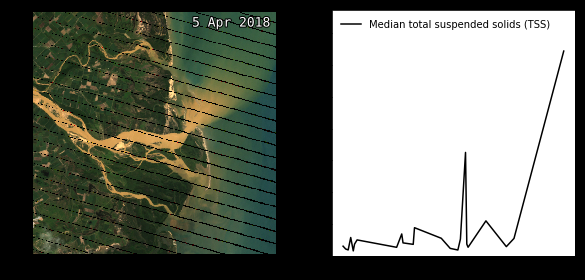

In [10]:
# Parameters for left hand panel
ds_left = ds1  # xarray dataset to use for left panel
bands1 = ['red', 'green', 'blue']  # bands to use for left panel
reflect_stand1 = 2500  # colour stretch for left panel

# Parameters for right hand panel
df_data = df_median  # pandas dataframe containing data for right panel
y_max = np.max(df_median.values) * 1.2  # y-axis max value for right panel

# Overall parameters
output_path = '{}_polydrill.gif'.format(study_area)  # output path for animation
interval = 500  # milliseconds between each frame


# Define function to convert xarray dataset to list of three band numpy arrays
def _ds_to_arrraylist(ds, bands, reflect_stand):   

    array_list = []
    for i, timestep in enumerate(ds.time):

        # Select single timestep from the data array
        ds_i = ds.isel(time = i)

        # Create new three band array
        y, x = ds_i[bands[0]].shape

        if len(bands) == 1:    

            # Create new three band array
            img_toshow = ds_i[bands[0]].values

        else:

            rawimg = np.zeros((y, x, 3), dtype=np.float32)

            # Add xarray bands into three dimensional numpy array
            for band, colour in enumerate(bands):

                rawimg[:, :, band] = ds_i[colour].values

            # Stretch contrast using defined reflectance standardisation; defaults to 5000
            img_toshow = (rawimg / reflect_stand).clip(0, 1)

        array_list.append(img_toshow)

    return(array_list)

# Prep line plot array
x = df_data.index
y1 = df_data.iloc[:,0]   

# Import image array
imagelist1 = _ds_to_arrraylist(ds_left, bands=bands1, reflect_stand=reflect_stand1)

# Set up figure
fig, (ax1, ax2) = plt.subplots(ncols=2) 
fig.patch.set_facecolor('black')
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
fig.set_size_inches(8.2, 4, forward=True)
ax1.axis('off')
ax2.set_ylabel('Total suspended solids (mg/L)')

# Initialise left panel
im1 = ax1.imshow(imagelist1[0])

# Initialise right panel
line1, = ax2.plot(x, y1, color='black', label='Median total suspended solids (TSS)', zorder=1)

# Legend to right panel
ax2.legend(loc='upper left', bbox_to_anchor=(0, 1),
          ncol=1, frameon=False) 

# Set up annotation params
annotation_kwargs = dict({'xy': (1, 1), 'xycoords':'axes fraction', 
                          'xytext':(-5, -5), 'textcoords':'offset points', 
                          'horizontalalignment':'right', 'verticalalignment':'top', 
                          'fontsize':13, 'color':'white', 'family':'monospace', 
                          'path_effects':[PathEffects.withStroke(linewidth=2, foreground='black')]})

# Initialise annotation objects to be updated during animation
t = ax1.annotate('', **annotation_kwargs)

def update(num):
    
    # Get human-readable date info (e.g. "16 May 1990")
    ts = ds_left.time.isel(time=num).dt
    year = ts.year.item()
    month = ts.month.item()
    day = ts.day.item()     
    title_date = '{} {} {}'.format(day, calendar.month_abbr[month], year)    
    
    # Update left panel
    im1.set_array(imagelist1[num])
    t.set_text(title_date) 
    
    # Update right panel
    line1.set_data(x[:num + 1], y1[:num + 1])
    line1.axes.axis(ymin=0, ymax=y_max)
    
    return [im1, t, line1]

fig.tight_layout()

# Generate animation
ani = animation.FuncAnimation(fig=fig, func=update, frames=len(imagelist1), interval=interval, blit=True) 

# Export as either MP4 or GIF
if output_path[-3:] == 'mp4':
    print('    Exporting animation to {}'.format(output_path))
    ani.save(output_path, dpi=100)

elif output_path[-3:] == 'wmv':
    print('    Exporting animation to {}'.format(output_path))
    ani.save(output_path, dpi=100, 
             writer=animation.FFMpegFileWriter(fps=1000 / interval, bitrate=4000, codec='wmv2'))

elif output_path[-3:] == 'gif':
    print('    Exporting animation to {}'.format(output_path))
    ani.save(output_path, dpi=100, writer='imagemagick')

else:
    print('    Output file type must be either .mp4, .wmv or .gif')


In [12]:
len(imagelist1)

23